# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What are we trying to solve using data science?



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## **Importing the Libraries**

In [3]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow.keras.applications as ap
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16

### **Let us load and unzip the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [4]:
path = "/content/drive/MyDrive/Facial_emotion_images.zip"
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()
#folder path
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Visualizing our Classes**

Let's look at our classes. 

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

### **Happy**

**Observations and Insights:** Unique features may include smiling faces, bright eyes, and overall positive facial expressions

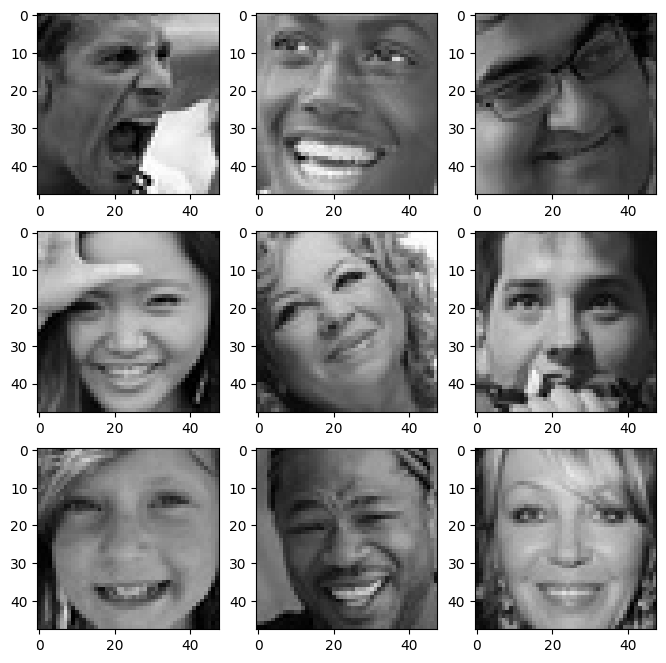

In [5]:
happy = "happy"
plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + happy + "/" +
                  os.listdir(folder_path + "train/" + happy)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

### **Sad**

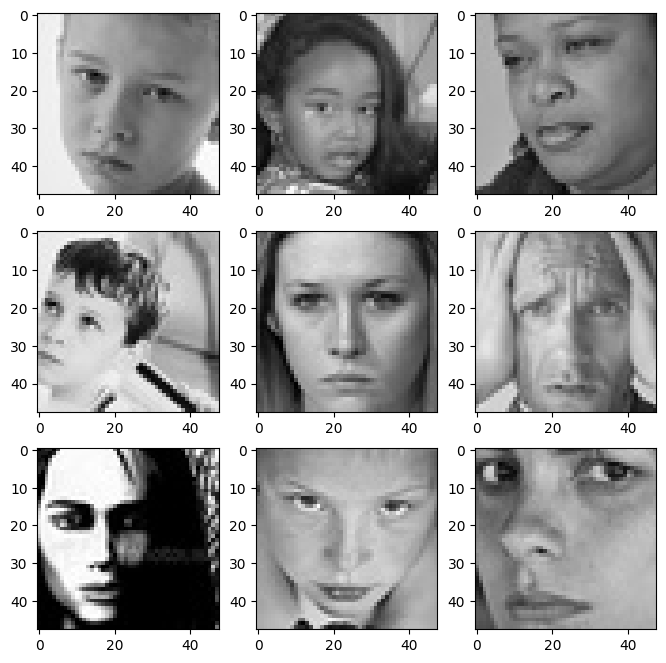

In [6]:
sad = "sad"
plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + sad + "/" +
                  os.listdir(folder_path + "train/" + sad)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations and Insights:** Unique features may include downcast eyes, frowning expressions, and overall expressions of sadness or grief

### **Neutral**

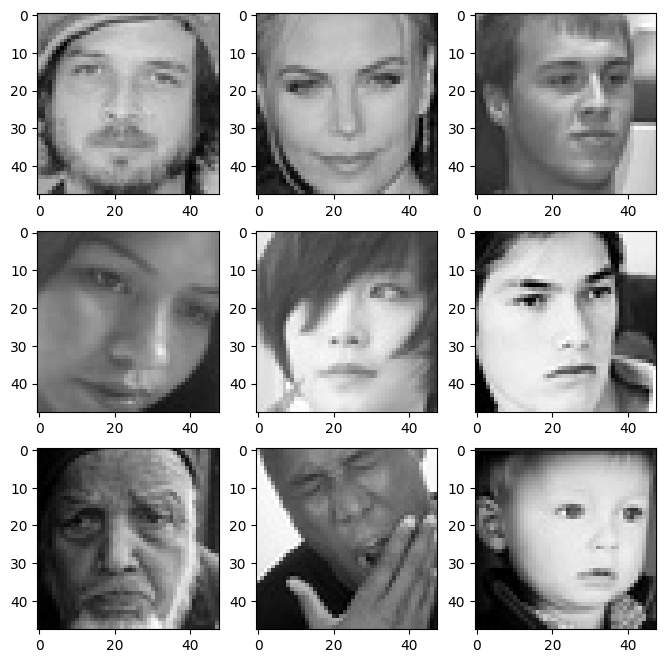

In [7]:
neutral = "neutral"
plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + neutral + "/" +
                  os.listdir(folder_path + "train/" + neutral)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations and Insights:** Unique features may include relaxed facial muscles, neutral facial expressions

### **Surprised**

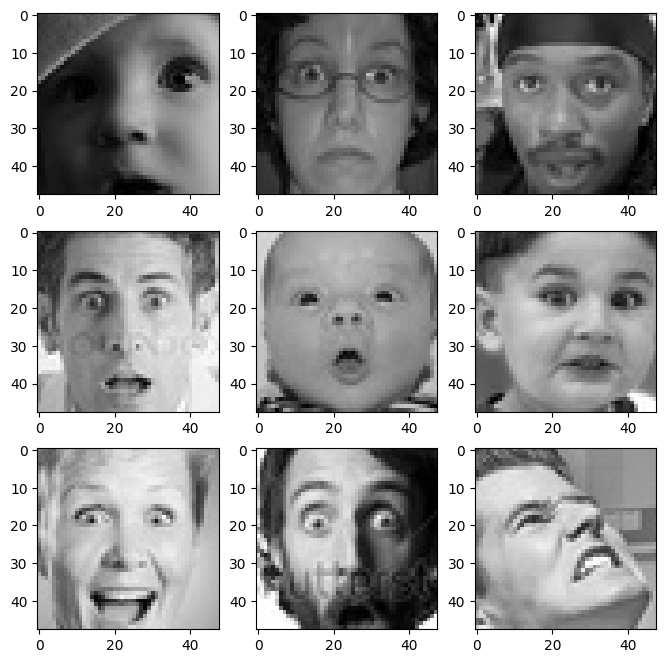

In [8]:
surprised = "surprise"
plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + surprised + "/" +
                  os.listdir(folder_path + "train/" + surprised)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations and Insights:** Unique features may include widened eyes, raised eyebrows, and an overall expression of disbelief

## **Checking Distribution of Classes**

In [9]:
#happy
num_happy = len(os.listdir(folder_path + "train/happy"))
print(num_happy)
#sad
num_sad = len(os.listdir(folder_path + "train/sad"))
print(num_sad)
#neutral
num_neutral = len(os.listdir(folder_path + "train/neutral"))
print(num_neutral)
#surprised
num_surprised = len(os.listdir(folder_path + "train/surprise"))
print(num_surprised)

3976
3982
3978
3173


**Observations and Insights:** The "happy" and "sad" classes have similar numbers of training samples, while the "neutral" class has slightly fewer samples, and the "surprised" class has the lowest number of samples

**Think About It:** 
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [10]:
batch_size  = 128
img_size = 48
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_set = train_datagen.flow_from_directory(folder_path + "train/",
                                              target_size = (img_size, img_size),
                                              batch_size = batch_size,
                                              color_mode = "grayscale",
                                              class_mode = "categorical",
                                              shuffle = True)
validation_set = val_datagen.flow_from_directory(folder_path + "validation/",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

test_set = test_datagen.flow_from_directory(folder_path + "test/",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead? 
* What are the advantages of CNNs over ANNs and are they applicable here?

### **Creating the Base Neural Network**

In [11]:
model1 = Sequential()

model1.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=(48, 48, 1)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

#first block
model1.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))


#flatten
model1.add(Flatten())

#dense
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='softmax'))



#summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       1

### **Compiling and Training the Model**

In [12]:
checkpoint = ModelCheckpoint("./model1.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model1.fit(train_set, validation_data = validation_set, epochs = epochs, callbacks=callbacks_list)



Epoch 1/5
119/119 [==============================] - ETA: 0s - loss: 1.4646 - accuracy: 0.4389

119/119 [==============================] - 131s 1s/step - loss: 1.4646 - accuracy: 0.4389 - val_loss: 1.4869 - val_accuracy: 0.3808 - lr: 0.0010
Epoch 2/5
119/119 [==============================] - ETA: 0s - loss: 1.1115 - accuracy: 0.5409

119/119 [==============================] - 121s 1s/step - loss: 1.1115 - accuracy: 0.5409 - val_loss: 1.0076 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 3/5
119/119 [==============================] - ETA: 0s - loss: 1.0216 - accuracy: 0.5706

119/119 [==============================] - 125s 1s/step - loss: 1.0216 - accuracy: 0.5706 - val_loss: 0.9441 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 4/5
119/119 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.5990

119/119 [==============================] - 121s 1s/step - loss: 0.9557 - accuracy: 0.5990 - val_loss: 0.8987 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 5/5
119/119 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.6199

119/119 [==============================] - 124s 1s/step - loss: 0.9091 - accuracy: 0.6199 - val_loss: 0.8750 - val_accuracy: 0.6349 - lr: 0.0010


### **Evaluating the Model on the Test Set**

In [13]:
test_images, test_labels = next(test_set)
accuracy = model1.evaluate(test_images, test_labels, verbose = 2)

4/4 - 0s - loss: 0.8739 - accuracy: 0.6328 - 168ms/epoch - 42ms/step


In [14]:
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")
    plt.show()


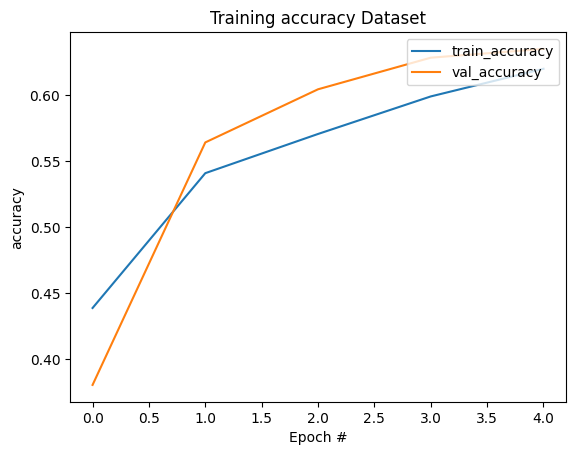

In [15]:
plot_history(history_1)

**Observations and Insights:** 
*   The model was trained for 5 epochs. Each epoch took around 120 seconds to complete.
*   During training, the loss decreased and the accuracy increased gradually with each epoch, indicating that the model was learning from the data.
*   The training accuracy reached around 62% at the end of the 5th epoch.
*   The validation accuracy was around 63.5%, which is slightly higher than the training accuracy. This suggests that the model generalized well to unseen data.
*   The model achieved a loss of 0.8739 and an accuracy of 63.28% on the test data, indicating its performance on unseen data.







### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [16]:
model2 = Sequential()

model2.add(Conv2D(256, kernel_size=2, padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

#first block
model2.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))
#flatten
model2.add(Flatten())

#dense
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Dense(4, activation='softmax'))



adam = optimizers.Adam(learning_rate = 0.0005)

#summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [25]:
checkpoint = ModelCheckpoint("./model2.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2 = model2.fit(train_set, validation_data = validation_set, epochs = epochs, callbacks=callbacks_list)



Epoch 1/5
119/119 [==============================] - ETA: 0s - loss: 1.0468 - accuracy: 0.5450

119/119 [==============================] - 711s 6s/step - loss: 1.0468 - accuracy: 0.5450 - val_loss: 1.0778 - val_accuracy: 0.5186 - lr: 0.0010
Epoch 2/5
119/119 [==============================] - ETA: 0s - loss: 0.9863 - accuracy: 0.5772

119/119 [==============================] - 713s 6s/step - loss: 0.9863 - accuracy: 0.5772 - val_loss: 1.2120 - val_accuracy: 0.4352 - lr: 0.0010
Epoch 3/5
119/119 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.6015

119/119 [==============================] - 715s 6s/step - loss: 0.9280 - accuracy: 0.6015 - val_loss: 1.2650 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 4/5
119/119 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.6255

119/119 [==============================] - 724s 6s/step - loss: 0.8874 - accuracy: 0.6255 - val_loss: 0.9288 - val_accuracy: 0.5891 - lr: 0.0010
Epoch 5/5
119/119 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.6337

119/119 [==============================] - 758s 6s/step - loss: 0.8644 - accuracy: 0.6337 - val_loss: 0.9487 - val_accuracy: 0.5660 - lr: 0.0010


### **Evaluating the Model on the Test Set**

In [26]:
test_images, test_labels = next(test_set)
accuracy = model2.evaluate(test_images, test_labels, verbose = 2)

4/4 - 1s - loss: 0.9166 - accuracy: 0.6172 - 1s/epoch - 256ms/step


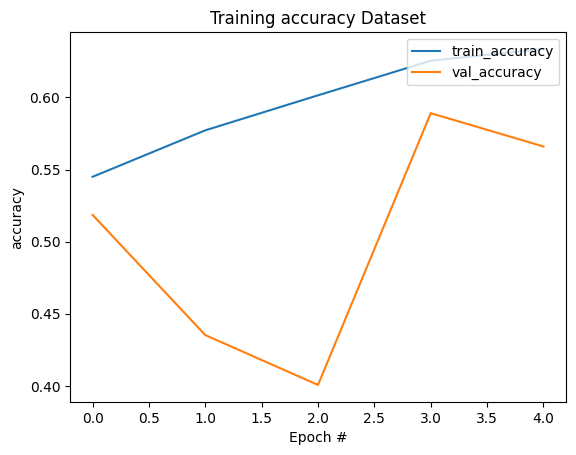

In [27]:
plot_history(history_2)

**Observations and Insights:** 
*   The model was trained for 5 epochs. Each epoch took a significant amount of time, around 700-760 seconds.
*   During training, the loss decreased and the accuracy increased gradually with each epoch, indicating that the model was learning from the data.
*   The training accuracy reached around 63.37% at the end of the 5th epoch.
*   The validation accuracy was around 56.60%, which is lower than the training accuracy. This suggests that the model may have overfit the training data and did not generalize well to unseen data.
*   The model achieved a loss of 0.9166 and an accuracy of 61.72% on the test data.



## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [28]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              classes = ["happy", "sad", "neutral", "surprise"],
                                              shuffle = True)

val_set = datagen_val.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              classes = ["happy", "sad", "neutral", "surprise"],
                                              shuffle = True)

test_set = datagen_test.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              classes = ["happy", "sad", "neutral", "surprise"],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 15109 images belonging to 4 classes.
Found 15109 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [29]:
model = VGG16(include_top = False, weights='imagenet', input_shape=(48,48,3))
model.summary

58889256/58889256 [==============================] - 1s 0us/step


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f5477492560>>

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [30]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [31]:
for layer in vgg_model.layers:
    layer.trainable = False

In [32]:
m = Sequential()

m = Flatten()(transfer_layer.output)

m = Dense(256, activation='relu')(m)
m = Dense(128, activation='relu')(m)

m = Dropout(0.3)(m)

m = Dense(64, activation='relu')(m)

m = BatchNormalization()(m)

m = Dense(4, activation='softmax')(m)

new_model = Model(model.input, m)

### **Compiling and Training the VGG16 Model**

In [33]:
checkpoint = ModelCheckpoint("./model3.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### **Evaluating the VGG16 model**

In [34]:
history_3 = new_model.fit(train_set, validation_data = val_set, epochs = 5)

Epoch 1/5
473/473 [==============================] - 886s 2s/step - loss: 0.5397 - accuracy: 0.4673 - val_loss: 0.4440 - val_accuracy: 0.5550
Epoch 2/5
473/473 [==============================] - 873s 2s/step - loss: 0.4570 - accuracy: 0.5430 - val_loss: 0.4267 - val_accuracy: 0.5743
Epoch 3/5
473/473 [==============================] - 885s 2s/step - loss: 0.4378 - accuracy: 0.5674 - val_loss: 0.4144 - val_accuracy: 0.5916
Epoch 4/5
473/473 [==============================] - 883s 2s/step - loss: 0.4212 - accuracy: 0.5904 - val_loss: 0.3758 - val_accuracy: 0.6427
Epoch 5/5
473/473 [==============================] - 884s 2s/step - loss: 0.3978 - accuracy: 0.6188 - val_loss: 0.3484 - val_accuracy: 0.6758


In [35]:
test_images, test_labels = next(test_set)
accuracy = new_model.evaluate(test_images, test_labels, verbose = 2)

1/1 - 1s - loss: 0.3324 - accuracy: 0.6875 - 834ms/epoch - 834ms/step


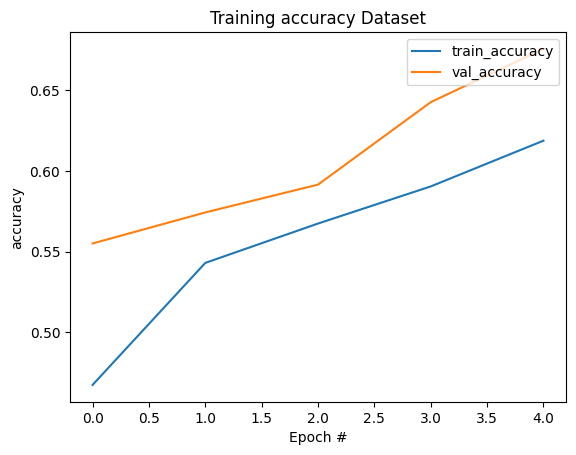

In [36]:
plot_history(history_3)

**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights:**
*   The model was trained for 5 epochs. Each epoch took a considerable amount of time, around 873-886 seconds.
*   Throughout the training process, the loss gradually decreased, while the accuracy increased.
*   The training accuracy reached approximately 61.88% at the end of the 5th epoch.
*   The validation accuracy also showed improvement, reaching around 67.58% at the end of the training.
*   The model achieved a loss of 0.3324 and an accuracy of 68.75% on the test data.



**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [37]:
resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
resnet.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [38]:
transfer_layer = resnet.get_layer('conv5_block3_add')

resnet.trainable = False

x = Flatten()(transfer_layer.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
pred = Dense(4, activation='softmax')(x)

model = Model(resnet.input, pred)

### **Compiling and Training the Model**

In [39]:
checkpoint = ModelCheckpoint("./model4.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_4 = model.fit(train_set, validation_data = val_set, epochs = epochs, callbacks=callbacks_list)

Epoch 1/5
473/473 [==============================] - ETA: 0s - loss: 1.4680 - accuracy: 0.3585

473/473 [==============================] - 642s 1s/step - loss: 1.4680 - accuracy: 0.3585 - val_loss: 1.1701 - val_accuracy: 0.4912 - lr: 0.0100
Epoch 2/5
473/473 [==============================] - ETA: 0s - loss: 1.2599 - accuracy: 0.4295

473/473 [==============================] - 570s 1s/step - loss: 1.2599 - accuracy: 0.4295 - val_loss: 1.1237 - val_accuracy: 0.5282 - lr: 0.0100
Epoch 3/5
473/473 [==============================] - ETA: 0s - loss: 1.1977 - accuracy: 0.4653

473/473 [==============================] - 610s 1s/step - loss: 1.1977 - accuracy: 0.4653 - val_loss: 1.0955 - val_accuracy: 0.5408 - lr: 0.0100
Epoch 4/5
473/473 [==============================] - ETA: 0s - loss: 1.1715 - accuracy: 0.4832

473/473 [==============================] - 618s 1s/step - loss: 1.1715 - accuracy: 0.4832 - val_loss: 1.0856 - val_accuracy: 0.5440 - lr: 0.0100
Epoch 5/5
473/473 [==============================] - ETA: 0s - loss: 1.1403 - accuracy: 0.4997

473/473 [==============================] - 571s 1s/step - loss: 1.1403 - accuracy: 0.4997 - val_loss: 1.0577 - val_accuracy: 0.5579 - lr: 0.0100


### **Evaluating the ResNet Model**

In [40]:
test_images, test_labels = next(test_set)
model.evaluate(test_images, test_labels, verbose = 2)

1/1 - 1s - loss: 1.0927 - accuracy: 0.6250 - 515ms/epoch - 515ms/step


[1.092699408531189, 0.625]

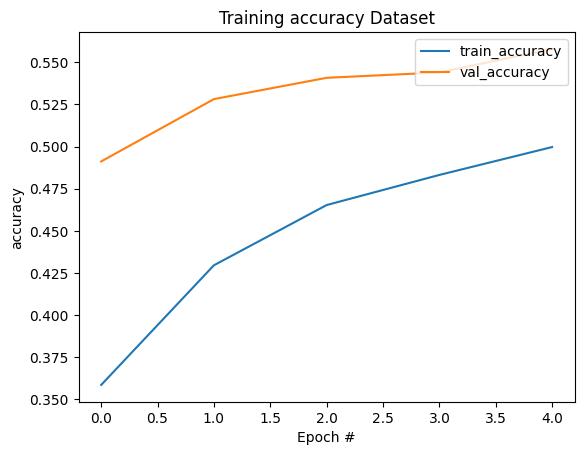

In [41]:
plot_history(history_4)

**Observations and Insights:**

*   The model trained for 5 epochs, with each epoch taking approximately 520 seconds. The training accuracy improved from 35.85% to 49.97%, while the validation accuracy increased from 49.12% to 55.79%.
*   Early stopping was applied, and the model achieved an accuracy of 62.5% on the test data



**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [42]:
effnet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))
effnet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [43]:
effnet.trainable = False

transfer_layer = effnet.output

x = Flatten()(transfer_layer)

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(4, activation='softmax')(x)

effnet_model = Model(inputs=effnet.input, outputs=predictions)

### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint("./model5.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
effnet_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_5 = effnet_model.fit(train_set, validation_data = val_set, epochs = epochs, callbacks=callbacks_list)

In [45]:
checkpoint = ModelCheckpoint("./model1.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 5
effnet_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_5 = effnet_model.fit(train_set, validation_data = val_set, epochs = epochs, callbacks=callbacks_list)

Epoch 1/5
473/473 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.6038
Epoch 1: val_loss improved from inf to 0.90937, saving model to ./model1.h5
473/473 [==============================] - 259s 520ms/step - loss: 0.9524 - accuracy: 0.6038 - val_loss: 0.9094 - val_accuracy: 0.6208 - lr: 0.0100
Epoch 2/5
473/473 [==============================] - ETA: 0s - loss: 0.9220 - accuracy: 0.6174
Epoch 2: val_loss improved from 0.90937 to 0.83348, saving model to ./model1.h5
473/473 [==============================] - 246s 520ms/step - loss: 0.9220 - accuracy: 0.6174 - val_loss: 0.8335 - val_accuracy: 0.6600 - lr: 0.0100
Epoch 3/5
473/473 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.6250
Epoch 3: val_loss improved from 0.83348 to 0.78726, saving model to ./model1.h5
473/473 [==============================] - 241s 510ms/step - loss: 0.8998 - accuracy: 0.6250 - val_loss: 0.7873 - val_accuracy: 0.6866 - lr: 0.0100
Epoch 4/5
473/473 [================

### **Evaluating the EfficientnetNet Model**

In [46]:
test_images, test_labels = next(test_set)
evaluation = effnet_model.evaluate(test_images, test_labels, verbose = 2)

1/1 - 0s - loss: 0.8058 - accuracy: 0.6875 - 192ms/epoch - 192ms/step


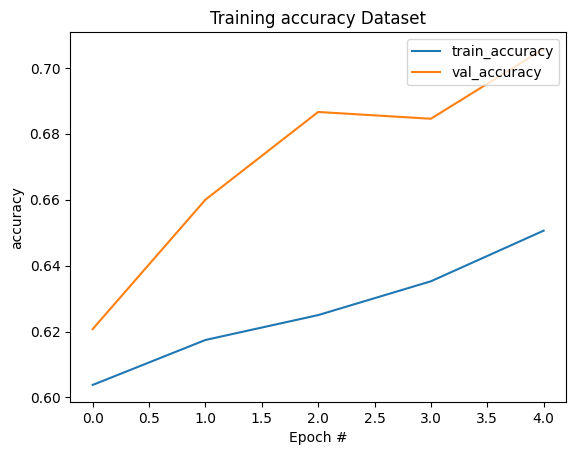

In [47]:
plot_history(history_5)

**Observations and Insights:**

*   The model trained for 5 epochs. The training accuracy improved from 60.38% to 65.06%, while the validation accuracy increased from 62.08% to 70.57%. 
*   Early stopping was applied, and the model achieved an accuracy of 68.75% on the test data.



**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [48]:
batch_size  = 128
img_size = 48
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_set = train_datagen.flow_from_directory(folder_path + "train/",
                                              target_size = (img_size, img_size),
                                              batch_size = batch_size,
                                              color_mode = "grayscale",
                                              class_mode = "categorical",
                                              shuffle = True)
validation_set = val_datagen.flow_from_directory(folder_path + "validation/",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

test_set = test_datagen.flow_from_directory(folder_path + "test/",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [49]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, kernel_size=2, padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Third Convolutional Block
model.add(Conv2D(512, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Fourth Convolutional Block
model.add(Conv2D(512, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Fifth Convolutional Block
model.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))



### **Compiling and Training the Model**

In [55]:
steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("./model6.h5", monitor = 'val_loss',
                            save_weights_only = True, model = 'min', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]
epochs = 5

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history_6 = model.fit(train_set, validation_data = validation_set, epochs = epochs, callbacks=callbacks)

Epoch 1/5
119/119 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.4465
Epoch 1: saving model to ./model6.h5
119/119 [==============================] - 489s 4s/step - loss: 1.2290 - accuracy: 0.4465 - val_loss: 1.1588 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 2/5
119/119 [==============================] - ETA: 0s - loss: 1.0191 - accuracy: 0.5599
Epoch 2: saving model to ./model6.h5
119/119 [==============================] - 453s 4s/step - loss: 1.0191 - accuracy: 0.5599 - val_loss: 1.1138 - val_accuracy: 0.4816 - lr: 0.0010
Epoch 3/5
119/119 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.6035
Epoch 3: saving model to ./model6.h5
119/119 [==============================] - 455s 4s/step - loss: 0.9290 - accuracy: 0.6035 - val_loss: 0.8555 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 4/5
119/119 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.6488
Epoch 4: saving model to ./model6.h5
119/119 [============================

### **Evaluating the Model on Test Set**

In [56]:
test_images, test_labels = next(test_set)
model.evaluate(test_images, test_labels, verbose = 2)

4/4 - 1s - loss: 0.6779 - accuracy: 0.7109 - 858ms/epoch - 215ms/step


[0.6779334545135498, 0.7109375]

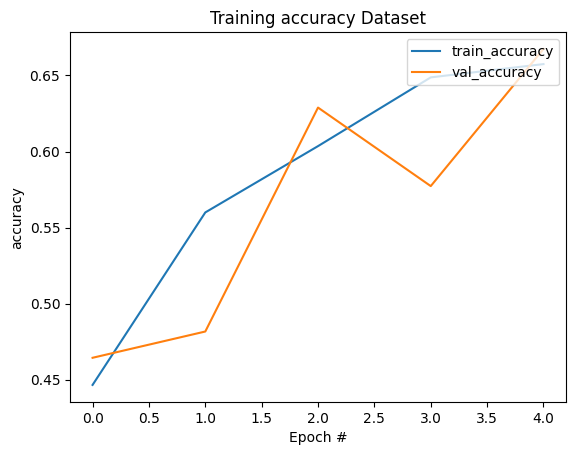

In [57]:
plot_history(history_6)

**Observations and Insights:**
*   The model's accuracy improves with each epoch, indicating that it is learning and making better predictions.
*   The training loss decreases over time, suggesting that the model is fitting the training data more effectively.
*   The validation accuracy also improves with each epoch, indicating that the model is generalizing well to unseen data.
*   The validation loss decreases over time, indicating that the model's predictions on the validation set are becoming more accurate.
*   The model's accuracy on the validation set is higher than its accuracy on the training set, which is a positive sign of good generalization.
*   The training process takes a significant amount of time per epoch, likely due to the large size of the dataset or the complexity of the model.
*  The final evaluation on the test set shows a loss of 0.6779 and an accuracy of 0.7109. This suggests that the model performs reasonably well on unseen data. 

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 1s 155ms/step


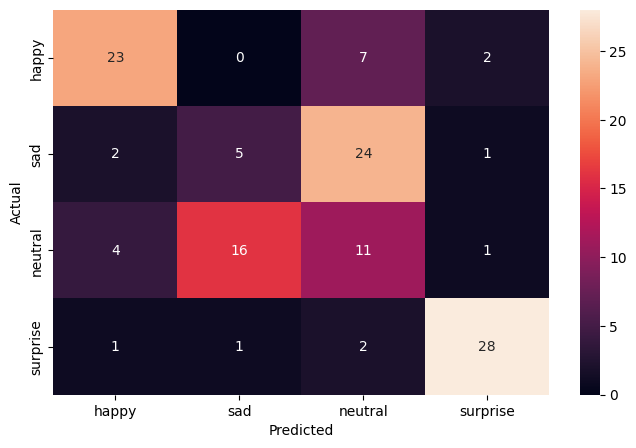

In [59]:
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)


pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:__**

## **Conclusion:**
The training time per epoch is relatively long, indicating that either the dataset is large or the model is computationally intensive. This could be a factor to consider when training the model on large datasets or limited computational resources.

The evaluation on the test set shows that the model achieves a reasonably high accuracy, ranging from 0.625 to 0.7109. This suggests that the model is capable of making accurate predictions on unseen data.

It is worth noting that in the first example, the model encountered a warning about saving the best model only with val_acc available, indicating that the model was not able to save the best model based on validation accuracy. This might be due to the absence of validation accuracy metric in the training process, which can be addressed by modifying the code to include this metric.

Stating that, Complex Neural Network model works the best for the dataset that is given.

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?